In [2]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

In [8]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np


mixit_visualize_subset_root = "../data/processed/mixit_visualize_subset"
paths = sorted(Path(mixit_visualize_subset_root).glob(f"**/*_source0.mp3"))
paths[:3]

[PosixPath('../data/processed/mixit_visualize_subset/audio/barswa/XC642687_source0.mp3'),
 PosixPath('../data/processed/mixit_visualize_subset/audio/brubru1/XC492937_source0.mp3'),
 PosixPath('../data/processed/mixit_visualize_subset/audio/colsun2/XC630277_source0.mp3')]

In [11]:
from birdclef import birdnet

birdnet_root = "../vendor/BirdNET-Analyzer"
model = birdnet.load_model_from_repo(birdnet_root)
model

In [12]:
prediction_func = birdnet.prediction_func(model)

In [46]:
import librosa
from birdclef.data.utils import slice_seconds

path = paths[5]
y, sr = librosa.load(path, sr=48_000)
X = slice_seconds(y, sr, seconds=3, step=3)
X.shape

(10, 144000)

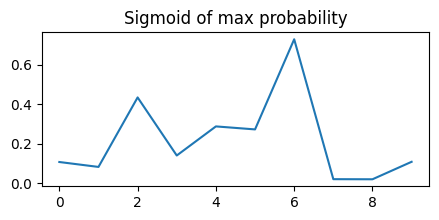

In [47]:
pred = prediction_func(X)[0]
pred_sigmoid = 1 / (1 + np.exp(-pred))

plt.figure(figsize=(5, 2))
plt.plot(pred_sigmoid.max(axis=1))
plt.title("Sigmoid of max probability")
plt.show()

Let's only keep the parts that are above a threshold.
We can be very conservative about this and keep things above the 0.5 threshold.

In [49]:
# get indices where max probability is above threshold
threshold = 0.2
pred_sigmoid_max = pred_sigmoid.max(axis=1)
probably_birdcall = np.where(pred_sigmoid_max > threshold)[0] * 3
probably_birdcall

array([ 6, 12, 15, 18])

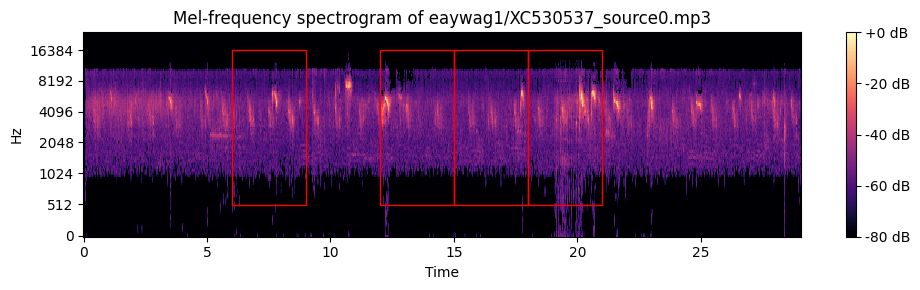

In [50]:
from IPython import display as ipd
import matplotlib.patches as patches

# lets draw this over a spectrogram
plt.figure(figsize=(10, 3))
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
S_dB = librosa.power_to_db(S, ref=np.max)
librosa.display.specshow(S_dB, sr=sr, x_axis="time", y_axis="mel")
plt.colorbar(format="%+2.0f dB")
plt.title(f"Mel-frequency spectrogram of {path.parts[-2]}/{path.parts[-1]}")
plt.tight_layout()

# let's draw a red box around probably birdcall regions
for i in probably_birdcall:
    rect = patches.Rectangle(
        (i, 500), 3, 16_000, linewidth=1, edgecolor="r", facecolor="none"
    )
    plt.gca().add_patch(rect)

plt.show()
ipd.display(ipd.Audio(path))

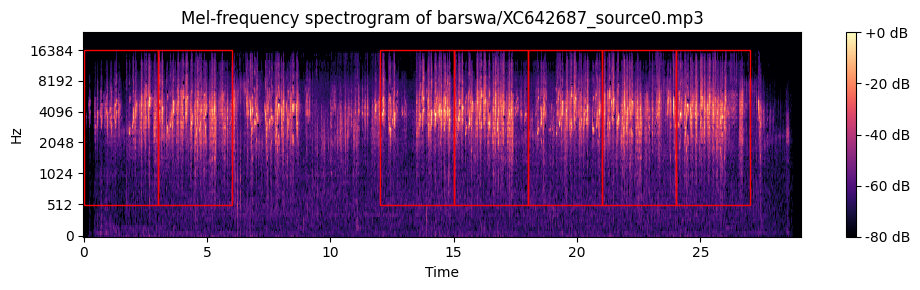

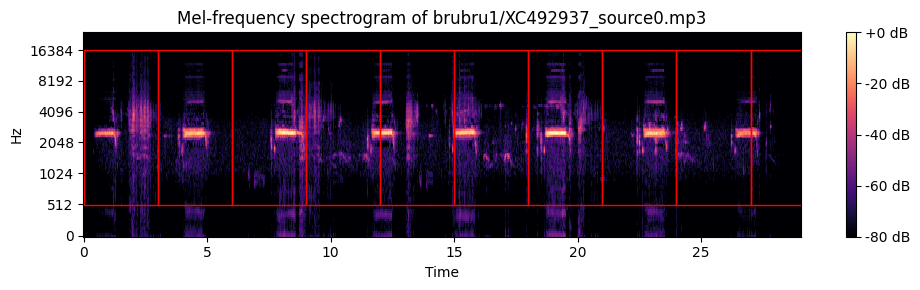

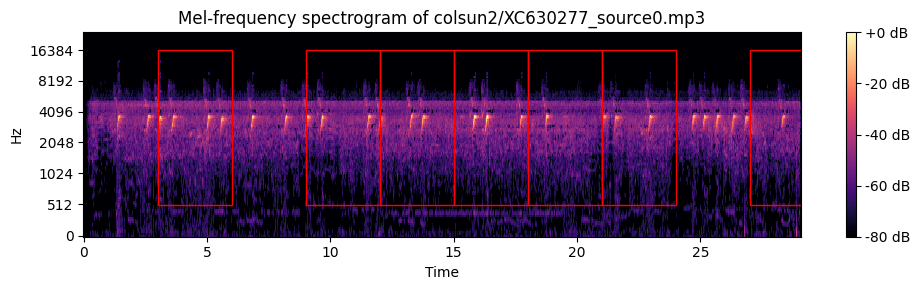

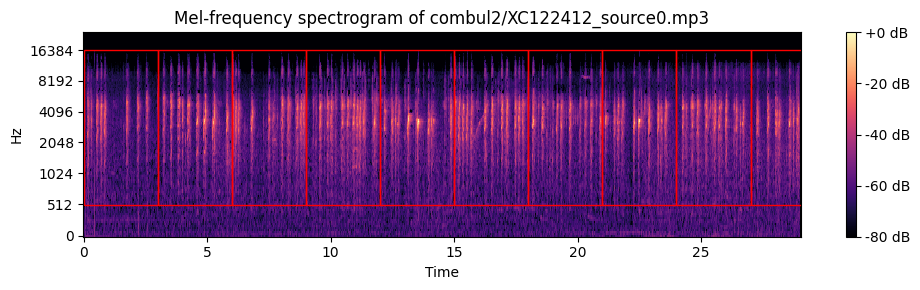

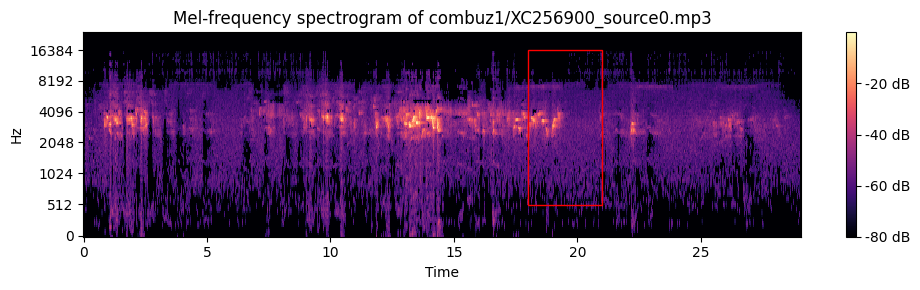

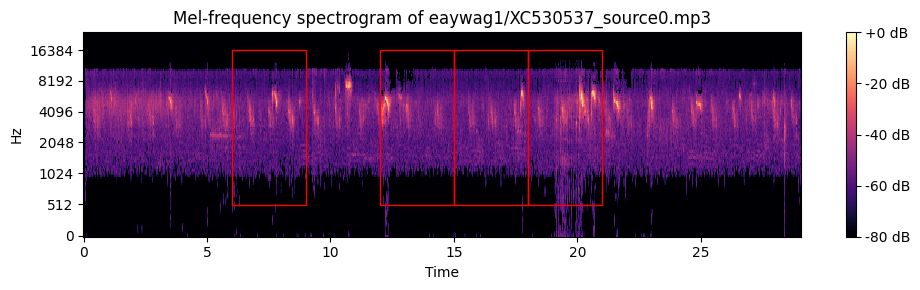

In [51]:
def predict_call(path, threshold=0.2):
    y, sr = librosa.load(path, sr=48_000)
    X = slice_seconds(y, sr, seconds=3, step=3)

    pred = prediction_func(X)[0]
    pred_sigmoid = 1 / (1 + np.exp(-pred))
    pred_sigmoid_max = pred_sigmoid.max(axis=1)
    probably_birdcall = np.where(pred_sigmoid_max > threshold)[0] * 3

    plt.figure(figsize=(10, 3))
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    S_dB = librosa.power_to_db(S, ref=np.max)
    librosa.display.specshow(S_dB, sr=sr, x_axis="time", y_axis="mel")
    plt.colorbar(format="%+2.0f dB")
    plt.title(f"Mel-frequency spectrogram of {path.parts[-2]}/{path.parts[-1]}")
    plt.tight_layout()

    for i in probably_birdcall:
        rect = patches.Rectangle(
            (i, 500), 3, 16_000, linewidth=1, edgecolor="r", facecolor="none"
        )
        plt.gca().add_patch(rect)
    plt.show()


for i in range(6):
    predict_call(paths[i], threshold=0.2)